In [1]:
!pip install pm4py

drive = True
dir = './data/'
if drive:
  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

  import sys
  sys.path.insert(0,'/content/drive/My Drive/Masterthesis')

  dir = '/content/drive/My Drive/Masterthesis/'

import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import pm4py


def import_xes(file_path):
    event_log = pm4py.read_xes(file_path)
    event_log['time:timestamp'] = pd.to_datetime(event_log['time:timestamp'], utc=True)
    return event_log


event_log_path = 'data/Sepsis.xes'

Mounted at /content/drive


In [2]:
# Read event_log from XES file and preprocess
event_log = import_xes(dir + event_log_path)

/usr/local/lib/python3.10/dist-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

In [3]:
print(event_log.head())
print(event_log.columns)
print(event_log[['concept:name', 'case:concept:name', 'time:timestamp']])

  InfectionSuspected org:group DiagnosticBlood DisfuncOrg SIRSCritTachypnea  \
0               True         A            True       True              True   
1                NaN         B             NaN        NaN               NaN   
2                NaN         B             NaN        NaN               NaN   
3                NaN         B             NaN        NaN               NaN   
4                NaN         C             NaN        NaN               NaN   

  Hypotensie SIRSCritHeartRate Infusion DiagnosticArtAstrup     concept:name  \
0       True              True     True                True  ER Registration   
1        NaN               NaN      NaN                 NaN       Leucocytes   
2        NaN               NaN      NaN                 NaN              CRP   
3        NaN               NaN      NaN                 NaN       LacticAcid   
4        NaN               NaN      NaN                 NaN        ER Triage   

   ...  DiagnosticLacticAcid lifecycle:trans

In [4]:
# cols specifies the attributes which should be taken into account to compute the uniqueness
def compute_uniqueness(df, cols):
    amount_cases = df.shape[0]
    unique_values_in_column = df[cols].drop_duplicates().shape[0]
    uniqueness_of_col = round(unique_values_in_column / amount_cases, 4) * 100
    return uniqueness_of_col

In [5]:
# Now let's focus on the uniqueness of traces
case_identifier = 'case:concept:name'
event_identifier = 'concept:name'
df_events_per_case = event_log[[case_identifier, event_identifier]]
df_events_per_case['count_events'] = event_log.groupby(case_identifier)[case_identifier].transform('count')
df_events_per_case = df_events_per_case.drop(event_identifier, axis=1)
df_events_per_case = df_events_per_case.drop_duplicates()

events = event_log.groupby(case_identifier)[event_identifier].agg(lambda x: ', '.join(str(val).strip() for val in x if pd.notna(val))).reset_index()
events.columns = [case_identifier, 'events']
df_events_per_case = pd.merge(df_events_per_case, events, on=case_identifier, how='left')

df_events_per_case

<ipython-input-5-3b0efca8e3df>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events_per_case['count_events'] = event_log.groupby(case_identifier)[case_identifier].transform('count')


,case:concept:name,count_events,events
0,A,22,"ER Registration, Leucocytes, CRP, LacticAcid, ..."
1,B,12,"ER Registration, ER Triage, CRP, LacticAcid, L..."
2,C,14,"ER Registration, ER Triage, ER Sepsis Triage, ..."
3,D,13,"ER Registration, ER Triage, ER Sepsis Triage, ..."
4,E,8,"ER Registration, ER Triage, ER Sepsis Triage, ..."
...,...,...,...
1045,HNA,30,"ER Registration, ER Triage, ER Sepsis Triage, ..."
1046,INA,3,"ER Registration, ER Triage, ER Sepsis Triage"
1047,JNA,3,"ER Registration, ER Triage, ER Sepsis Triage"
1048,KNA,15,"ER Registration, ER Triage, ER Sepsis Triage, ..."


In [9]:
uniqueness_of_traces = compute_uniqueness(df_events_per_case, 'events')
print("Overall trace uniqueness: {} %".format(uniqueness_of_traces))

Overall trace uniqueness: 80.57 %


In [12]:
# Compute the uniqueness of each activity --> With which probability can I reidentify a case (trace) given that a specific activity is contained in the trace
total_amount_traces = df_events_per_case.shape[0]
total_amount_events = event_log[event_identifier].unique().shape[0]
all_events = event_log[event_identifier].unique()
uniqueness_containing_activity = pd.DataFrame(all_events, columns=['events'])
counts = {}
appears = {}

def helper_count(row, activity_code):
    total_counts = str(row).count(str(activity_code))
    return 1 if total_counts > 0 else 0

for event in all_events:
    counts[str(event)] = int(df_events_per_case['events'].apply(lambda row: str(row).count(str(event))).values.sum())
    appears[str(event)] = df_events_per_case['events'].apply(lambda row: helper_count(row, event)).values.sum()

df_unique_events = pd.DataFrame([counts.keys(), counts.values(), appears.values()]).T
df_unique_events.columns = [event_identifier, 'total counts', 'containedInTrace']

# Compute uniqueness
df_unique_events['uniqueness'] = 1 - (df_unique_events['containedInTrace'] - 1) / total_amount_traces

print(df_unique_events.sort_values('uniqueness', ascending=False))

        concept:name total counts containedInTrace uniqueness
15         Release E            6                6   0.995238
14         Release D           24               24   0.978095
13         Release C           25               25   0.977143
12         Release B           56               56   0.947619
11      Admission IC          117              110    0.89619
10         Return ER          294              294   0.720952
9          Release A          671              671   0.361905
6          IV Liquid          753              753    0.28381
8       Admission NC         1182              800   0.239048
7     IV Antibiotics          823              823   0.217143
3         LacticAcid         1466              860   0.181905
2                CRP         3262             1007   0.041905
1         Leucocytes         3383             1012   0.037143
5   ER Sepsis Triage         1049             1049   0.001905
0    ER Registration         1050             1050   0.000952
4       

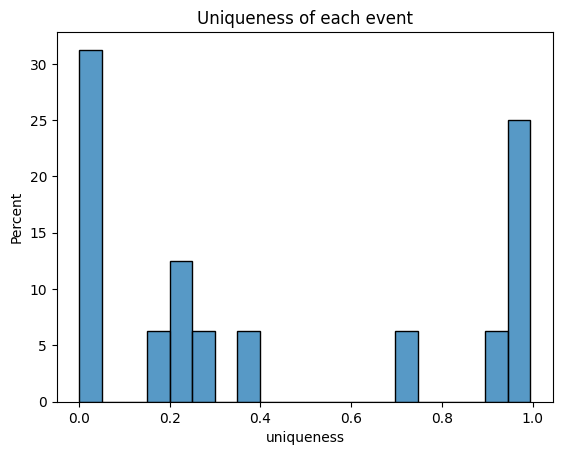

Bin 1 -  Count: 5, Percentage: 31.25 %
Bin 2 -  Count: 0, Percentage: 0.0 %
Bin 3 -  Count: 0, Percentage: 0.0 %
Bin 4 -  Count: 1, Percentage: 6.25 %
Bin 5 -  Count: 2, Percentage: 12.5 %
Bin 6 -  Count: 1, Percentage: 6.25 %
Bin 7 -  Count: 0, Percentage: 0.0 %
Bin 8 -  Count: 1, Percentage: 6.25 %
Bin 9 -  Count: 0, Percentage: 0.0 %
Bin 10 -  Count: 0, Percentage: 0.0 %
Bin 11 -  Count: 0, Percentage: 0.0 %
Bin 12 -  Count: 0, Percentage: 0.0 %
Bin 13 -  Count: 0, Percentage: 0.0 %
Bin 14 -  Count: 0, Percentage: 0.0 %
Bin 15 -  Count: 1, Percentage: 6.25 %
Bin 16 -  Count: 0, Percentage: 0.0 %
Bin 17 -  Count: 0, Percentage: 0.0 %
Bin 18 -  Count: 0, Percentage: 0.0 %
Bin 19 -  Count: 1, Percentage: 6.25 %
Bin 20 -  Count: 4, Percentage: 25.0 %

0 activities are completely unique


In [13]:
def print_and_visualize_hist_plot(df, col_name, amount_bins, hist_title, total_amount):

    sns.histplot(df[col_name], bins=amount_bins, stat='percent').set(title=hist_title)
    plt.show()

    hist_values, bin_edges = np.histogram(df[col_name], bins=amount_bins)

    # Print out the histogram values
    for i in range(len(hist_values)):
        print(f"Bin {i+1} -  Count: {hist_values[i]}, Percentage: {round(hist_values[i]/total_amount, 4) * 100} %")

    # Count of activities which have a uniqueness of 100%
    amount_completely_unique_activities = df[df[col_name] == 1][col_name].count()
    print("\n{} activities are completely unique".format(amount_completely_unique_activities))

print_and_visualize_hist_plot(df=df_unique_events, col_name='uniqueness', amount_bins=20, hist_title='Uniqueness of each event',total_amount=total_amount_events)

In [15]:
# unique traces in the event log not considering the order of execution of the activities and how many times each activity was executed

df_activites_per_case_as_set = df_events_per_case
# Convert String to list, then to set to remove duplicates and then convert set back to list to order the elements. Finally, convert list back to a String
df_activites_per_case_as_set['Ordered Event Set'] = df_events_per_case['events'].apply(lambda row: ", ".join(sorted(list(set(row.split(", "))))))

# Compute Uniqueness
unordered_set_uniquness_of_activities = compute_uniqueness(df_activites_per_case_as_set, cols=['Ordered Event Set'])
print("{} % of traces are unique not considering the order of execution of the activities and how many times each activity was executed".format(unordered_set_uniquness_of_activities))

6.1899999999999995 % of traces are unique not considering the order of execution of the activities and how many times each activity was executed


In [16]:
df_events_per_case

,case:concept:name,count_events,events,Ordered Event Set
0,A,22,"ER Registration, Leucocytes, CRP, LacticAcid, ...","Admission NC, CRP, ER Registration, ER Sepsis ..."
1,B,12,"ER Registration, ER Triage, CRP, LacticAcid, L...","Admission NC, CRP, ER Registration, ER Sepsis ..."
2,C,14,"ER Registration, ER Triage, ER Sepsis Triage, ...","Admission NC, CRP, ER Registration, ER Sepsis ..."
3,D,13,"ER Registration, ER Triage, ER Sepsis Triage, ...","Admission NC, CRP, ER Registration, ER Sepsis ..."
4,E,8,"ER Registration, ER Triage, ER Sepsis Triage, ...","CRP, ER Registration, ER Sepsis Triage, ER Tri..."
...,...,...,...,...
1045,HNA,30,"ER Registration, ER Triage, ER Sepsis Triage, ...","Admission IC, Admission NC, CRP, ER Registrati..."
1046,INA,3,"ER Registration, ER Triage, ER Sepsis Triage","ER Registration, ER Sepsis Triage, ER Triage"
1047,JNA,3,"ER Registration, ER Triage, ER Sepsis Triage","ER Registration, ER Sepsis Triage, ER Triage"
1048,KNA,15,"ER Registration, ER Triage, ER Sepsis Triage, ...","Admission NC, CRP, ER Registration, ER Sepsis ..."
